In [3]:
import numpy as np 
import pandas as pd 
import gc
import matplotlib.pyplot as plt
import seaborn as sns

#### <font color='darkblue'> Doing these exercises, we had to be very careful about managing the RAM of our personal computers. We had to run this code with the 8gb RAM of our computers. So we tried to delete each dataframe as soon as we didn't need it anymore, and we also used the gc.collect() function. For every exercise, we uploaded only the part we needed from the main dataset.</font>

### <font color='purple'>Question 1:</font>
#### <font color='purple'>A marketing funnel describes your customer’s journey with your e-commerce. It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond. Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. Which is the rate of complete funnels?</font>

In [161]:
chunks_oct = pd.read_csv('2019-Oct.csv',chunksize=1000000, header='infer',usecols=["event_type",
"product_id","user_id"])

chunks_nov = pd.read_csv('2019-Nov.csv',chunksize=1000000, header='infer',usecols=["event_type",
"product_id","user_id"])

dataset=pd.DataFrame()
for chunk in chunks_oct:
    chunk = chunk[chunk["event_type"]!="view"]
    dataset= pd.concat([dataset,chunk])
for chunk in chunks_nov:
    chunk = chunk[chunk["event_type"]!="view"]
    dataset= pd.concat([dataset,chunk])

In [162]:
# rate of complete funnels :
# In order to have a complete funnel, we need a certain user to execute a "purchase" action after having executed
# a "cart" action. The "view" action has obviously happened before, so there is no need to consider it. This is why we will 
# work with a database containing only the "purchase" and "cart" actions. We will count one complete funnel everytime a 
# user performs a "purchase" action on a product, but only if the same user previously performed a "cart" action on the same
# product.

x=dataset.groupby(["user_id","product_id"]) # we group the actions of the same user on the same product

complete_funnels=0
for name,group in x:
    cart=0
    purchase=0
    for i in range(group.shape[0]):
        event = group.iloc[i]["event_type"]
        if event == "cart":
            cart=cart+1
        elif event == "purchase" and cart>purchase: #we accept a "purchase" only if a "cart" event has happened before
            purchase=purchase+1
    complete_funnels=complete_funnels+purchase

complete_funnels

1116168

### <font color='purple'>Question 1:</font>
#### <font color='purple'>What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).</font>

In [164]:
dataset=pd.DataFrame()

In [165]:
df_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=[ "event_type","user_session"])

In [166]:
gc.collect()

37

In [167]:
df_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=[ "event_type","user_session"])

In [168]:
dataset= pd.concat([df_oct,df_nov])

In [169]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109950743 entries, 0 to 67501978
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   event_type    object
 1   user_session  object
dtypes: object(2)
memory usage: 2.5+ GB


In [170]:
n_session = dataset['user_session'].nunique() # we calculate the total number of sessions

In [171]:
actions = dataset['event_type'].value_counts() # we calculate the number of each action

In [172]:
avg_actions = actions/n_session

In [174]:
avg_actions.values

array([4.53304495, 0.17185151, 0.07211249])

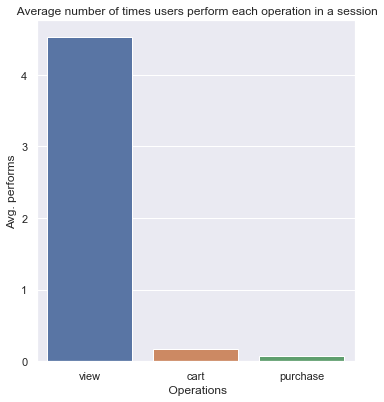

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(5.7, 6.27)
ax = sns.barplot(avg_actions.index,avg_actions.values)
ax.set(xlabel=' Operations', ylabel='Avg. performs')
plt.title(" Average number of times users perform each operation in a session")
plt.show()

#### <font color='blue'>As expected, the "view" actions are way more common than the "cart" and "purchase" actions.</font>

### <font color='purple'>Question 1:</font>
#### <font color='purple'>How many times, on average, a user views a product before adding it to the cart?</font>

In [182]:
dataset=pd.DataFrame()

In [184]:
df_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=[ "event_type"])

In [185]:
df_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=[ "event_type"])

In [186]:
dataset= pd.concat([df_oct,df_nov])

In [187]:
actions['view']/actions['cart']

26.37768509543551

### <font color='purple'>Question 1:</font> 
#### <font color='purple'>What’s the probability that products added once to the cart are effectively bought?</font> 

In [188]:
# We need to calculate in which percentage a "cart" action actually becomes a "complete funnel". Again, we consider 
# that the "view" event has obviously happened before.
print("Percentage probability that products added once to the cart are effectively bought:")
complete_funnels/actions['cart']*100

Percentage probability that products added once to the cart are effectively bought:


28.218511894739557

### <font color='purple'>Question 1:</font> 
#### <font color='purple'>What’s the average time an item stays in the cart before being removed?</font> 

In [17]:
# For this question, we will work with a database which doesn't contain the "view" actions. Since there is no
# "remove_from_cart" event_type, we will calculate the average time difference between the first "cart" action of a user
# on a product and the first "purchase" action, since purchasing the item removes it from the cart
dataset=pd.DataFrame()
chunks_oct = pd.read_csv('2019-Oct.csv',chunksize=1000000, header='infer',usecols=["event_time", "event_type",
"product_id","user_id"])
chunks_nov = pd.read_csv('2019-Nov.csv',chunksize=1000000, header='infer',usecols=["event_time", "event_type",
"product_id","user_id"])

for chunk in chunks_oct:
    chunk = chunk[chunk["event_type"]!="view"]
    chunk["event_time"]= pd.to_datetime(chunk["event_time"])
    dataset= pd.concat([dataset,chunk])
for chunk in chunks_nov:
    chunk = chunk[chunk["event_type"]!="view"]
    chunk["event_time"]= pd.to_datetime(chunk["event_time"])
    dataset= pd.concat([dataset,chunk])

In [18]:
z=dataset.groupby(["user_id","product_id"]) # we group the actions of the same user on the same product
tot_time=list() # the "time passed between the first "cart" and a "purchase"
for name,group in z:
    added=  False # this condition will turn True when the product is added for the first time by the user
    bought = False # this condition will turn True when the product is bought by the user
    for i in range(group.shape[0]):
        event = group.iloc[i]["event_type"]
        if event == "cart" and not added:
            add_time= group.iloc[i]["event_time"]
            added=True # the product has been added to the cart
        elif event=="purchase" and added and not bought:
            buy_time= group.iloc[i]["event_time"]
            bought= True # the product has been bought
        elif bought and added:
            break # we already found the first "cart" and the purchase time for this user and this product, so we can go to the next product/user
    if bought and added:
        tot_time.append(buy_time-add_time)
tot_time=np.array(tot_time)
counter=0
y=pd.to_timedelta(0)
while len(tot_time)>=1000: 
    x=tot_time[:1000]
    tot_time=tot_time[1001:]
    y=y+x.mean()
    counter=counter+1
average_time=y/counter

In [19]:
average_time

Timedelta('0 days 08:20:19.416349')

#### <font color='blue'>On average, when a user adds a product in the cart, it will take almost 8 hours and an half for him to decide to actually buy the product</font>

### <font color='purple'>Question 1:</font> 
#### <font color='purple'>How much time passes on average between the first view time and a purchase/addition to cart?</font>

In [21]:
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
dataset=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


#### <font color='darkblue'>For this exercise, we had to find a way to reduce the dataset in order to run the code just by using the 8gb ram of our personal computers. We decided to focus our analysis only on products with an high price. The reason for this is that we are looking for the average time between the first view time and a purchase/addition to cart. If the user sees a product with a low price and he is interested in it, he probably adds the product, or purchases it, as soon as he sees it. If he isn't interested, he simply won't add the product. So the average time between first view and a purchase/add to cart it's not really meaningful for products with a low price. Instead, when an user sees an high price product, even if he is interested in it, he will need some time to think about it. Understanding how much time the user needs to decide to buy the high price product or not is interesting for the company, because during that time the company might try to convince the user with, for example, a little discount. </font>

In [22]:
chunks_oct = pd.read_csv('2019-Oct.csv',chunksize=1000000, header='infer',usecols=["event_time", "event_type","price",
"product_id","user_id"])

chunks_nov = pd.read_csv('2019-Nov.csv',chunksize=1000000, header='infer',usecols=["event_time", "event_type","price",
"product_id","user_id"])

for chunk in chunks_oct:
    chunk = chunk[chunk["price"]>500]
    chunk["event_time"]= pd.to_datetime(chunk["event_time"])
    dataset= pd.concat([dataset,chunk])
for chunk in chunks_nov:
    chunk = chunk[chunk["price"]>500]
    chunk["event_time"]= pd.to_datetime(chunk["event_time"])
    dataset= pd.concat([dataset,chunk])

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18480132 entries, 2 to 67501978
Data columns (total 5 columns):
 #   Column      Dtype              
---  ------      -----              
 0   event_time  datetime64[ns, UTC]
 1   event_type  object             
 2   product_id  int64              
 3   price       float64            
 4   user_id     int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(1)
memory usage: 846.0+ MB


In [24]:
z=dataset.groupby(["product_id","user_id"]) # we group the actions of the same user on the same product
tot_time=list() # a list of the "time passed between the first view and a purchase/addition to cart"
for name,group in z:
    seen=  False # this condition will turn True when the product is seen for the first time by the user
    added = False # this condition will turn True when the product is bought or added to the cart by the user
    for i in range(group.shape[0]):
        event = group.iloc[i]["event_type"]
        if event == "view" and not seen:
            view_time= group.iloc[i]["event_time"]
            seen=True # the product has been seen
        elif event!="view" and seen and not added:
            add_time= group.iloc[i]["event_time"]
            added= True # the product has been bought/added to the cart
        elif seen and added:
            break # we already found the first view time and the cart/purchase time for this user and this product, so we can go to the next product/user
    if seen and added:
        tot_time.append(add_time-view_time)
tot_time=np.array(tot_time)
counter=0
y=pd.to_timedelta(0)
while len(tot_time)>=1000: 
    x=tot_time[:1000]
    tot_time=tot_time[1001:]
    y=y+x.mean()
    counter=counter+1
average_time=y/counter

In [26]:
average_time

Timedelta('2 days 18:51:47.728509')

#### <font color='darkblue'> As expected, when a user sees an expensive product which he is interested in , he needs some time to think about the purchase, almost 3 days. </font>

In [ ]:
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

### <font color='purple'>Question 2:</font> 
##### <font color='purple'>What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.</font>

In [159]:
import pandas as pd 
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()

In [74]:
## reading data for October 2019:
df_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=["event_type","category_code"])

In [4]:
dataset_oct=df_oct[df_oct['category_code'].notna()] # eliminating missing data

In [5]:
dataset_oct=dataset_oct[dataset_oct.event_type=='purchase'] # we are looking for the "purchase" actions

In [6]:
dataset_oct.info # we check our work

<bound method DataFrame.info of          event_type                category_code
162        purchase       electronics.smartphone
308        purchase       electronics.smartphone
442        purchase    furniture.bathroom.toilet
574        purchase  electronics.audio.headphone
603        purchase  electronics.audio.headphone
...             ...                          ...
42447959   purchase       electronics.smartphone
42448173   purchase     construction.tools.light
42448271   purchase       electronics.smartphone
42448362   purchase       electronics.smartphone
42448657   purchase  electronics.audio.headphone

[569424 rows x 2 columns]>

In [7]:
# extracting category section from category_code data
dataset_oct_cat=dataset_oct
dataset_oct_cat['category_code']=dataset_oct_cat['category_code'].str.split('.').str[0]

In [73]:
dataset_oct.info

<bound method DataFrame.info of                         event_time event_type
162      2019-10-01 00:02:14+00:00   purchase
308      2019-10-01 00:04:37+00:00   purchase
379      2019-10-01 00:06:02+00:00   purchase
442      2019-10-01 00:07:07+00:00   purchase
574      2019-10-01 00:09:26+00:00   purchase
...                            ...        ...
42448148 2019-10-31 23:55:13+00:00   purchase
42448173 2019-10-31 23:55:21+00:00   purchase
42448271 2019-10-31 23:56:03+00:00   purchase
42448362 2019-10-31 23:56:53+00:00   purchase
42448657 2019-10-31 23:59:16+00:00   purchase

[742849 rows x 2 columns]>

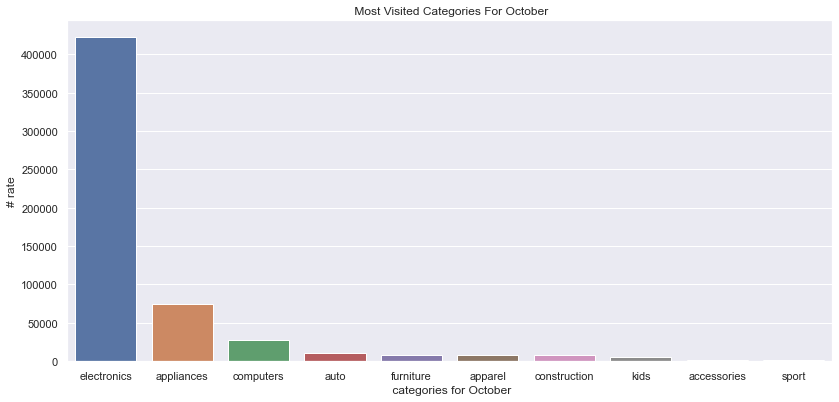

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 6.27)
x=dataset_oct_cat.groupby('category_code').category_code.count().nlargest(10) # we are looking for the top 10
ax = sns.barplot(x.index,x.values)
ax.set(xlabel=' categories for October', ylabel='# rate')
plt.title(" Most Visited Categories For October")
plt.show()

In [9]:
# reading data for November 2019 
df_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=["event_type","category_code"])

In [10]:
dataset_nov=df_nov[df_nov['category_code'].notna()] # eliminating missing data

In [11]:
dataset_nov=dataset_nov[dataset_nov.event_type=='purchase'] # we are looking for the "purchase" actions

In [12]:
dataset_nov.info # we check the data

<bound method DataFrame.info of          event_type                  category_code
107        purchase          furniture.bedroom.bed
168        purchase         electronics.smartphone
707        purchase         electronics.smartphone
939        purchase           electronics.video.tv
942        purchase    electronics.audio.subwoofer
...             ...                            ...
67501716   purchase         electronics.smartphone
67501725   purchase         electronics.smartphone
67501745   purchase         electronics.smartphone
67501824   purchase         electronics.smartphone
67501863   purchase  appliances.environment.vacuum

[682721 rows x 2 columns]>

In [13]:
# extracting category section from category_code data
dataset_nov_cat=dataset_nov 
dataset_nov_cat['category_code']=dataset_nov_cat['category_code'].str.split('.').str[0] 

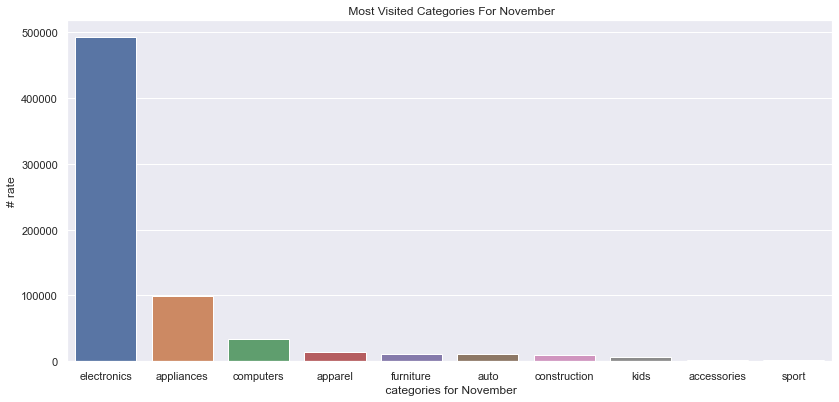

In [59]:
# November
# We look for the top 10 categories by sales
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 6.27)
x=dataset_nov_cat.groupby('category_code').category_code.count().nlargest(10)
ax = sns.barplot(x.index,x.values)
ax.set(xlabel=' categories for November', ylabel='# rate')
plt.title(" Most Visited Categories For November")
plt.show()

#### <font color='blue'>In both months, "Electronics" is the most visited category by a wide margin.</font>

In [160]:
import gc
gc.collect()


100

### <font color='purple'>Question 2:</font> 
##### <font color='purple'>plot the most visited subcategories for each month</font> 

In [18]:
dataset_oct1=df_oct[df_oct['category_code'].notna()]  # eliminating missing data

In [19]:
oct_view=dataset_oct1[dataset_oct1.event_type=='view'] # extracting data with event_type= view


In [ ]:
# we will extract the subcategory from the "category_code" column. We consider as "subcategory" the last part of the
# "category_column" string.

In [23]:
oct_view_subcat=oct_view

In [25]:
oct_view_subcat['category_code']=oct_view_subcat['category_code'].str.split('.').str[-1]

In [ ]:
## October 

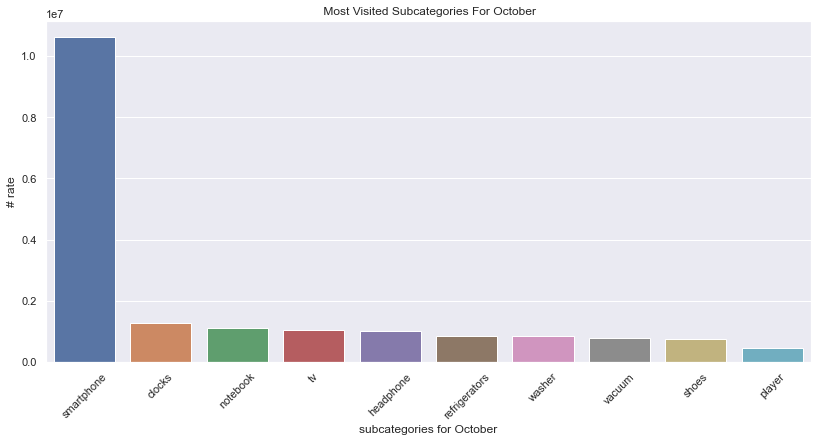

In [58]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 6.27)
x=oct_view_subcat.groupby('category_code').category_code.count().nlargest(10)
ax = sns.barplot(x.index,x.values)
ax.set(xlabel='subcategories for October', ylabel='# rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title(" Most Visited Subcategories For October")
plt.show()

In [32]:
import gc
gc.collect()
print("Free the memory")

Free the memory


In [33]:
dataset_nov1=df_nov[df_nov['category_code'].notna()] 

In [34]:
nov_view=dataset_nov1[dataset_nov1.event_type=='view'] # extracting data with event_type= view

In [35]:
nov_view_subcat=nov_view 

In [ ]:
nov_view_subcat['category_code']=nov_view_subcat['category_code'].str.split('.').str[-1]

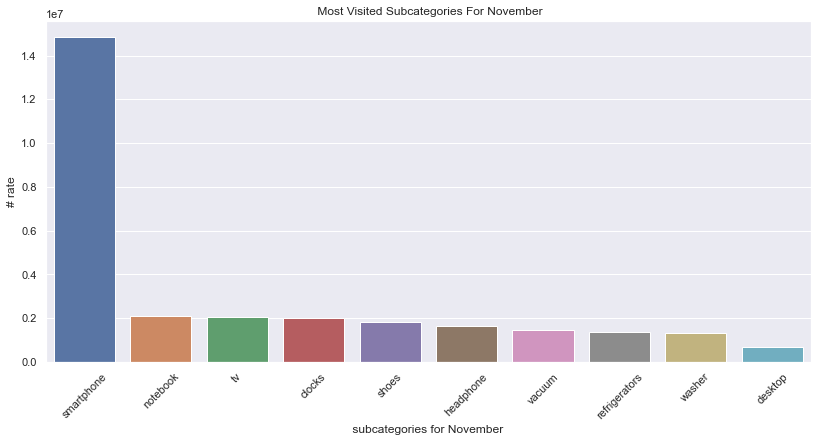

In [57]:
# November
# We look for the top 10 categories by sales
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 6.27)
x=nov_view_subcat.groupby('category_code').category_code.count().nlargest(10) # temp variable
ax = sns.barplot(x.index,x.values)
ax.set(xlabel=' subcategories for November ', ylabel='# rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title(" Most Visited Subcategories For November") 
plt.show()

#### <font color='blue'>In both months, "Smartphone" is the most visited subcategory by a wide margin. "Smartphone" is a subcategory of "Electronics", which is the most visited category</font>

In [194]:
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


### <font color='purple'>What are the 10 most sold products per category in each month?</font>

In [ ]:
## OCTOBER 2019 :

In [38]:
col_list1=["product_id"] # we aim to add column of product_id to previous loaded data 

In [39]:
a= pd.read_csv('2019-Oct.csv', sep=',',usecols=col_list1) # use it as temporary variable because we want concat it

In [40]:
df_oct_m=pd.concat([df_oct,a],axis=1) # concatenate the extra column

In [42]:
data_oct=df_oct_m[df_oct_m['category_code'].notna()]

In [43]:
data_oct=data_oct[data_oct.event_type=='purchase']

In [44]:
data_oct_cat=data_oct # to avoid miss indexing
data_oct_cat['category_code']=data_oct_cat['category_code'].str.split('.').str[0]

In [47]:
categories_oct = data_oct_cat.groupby('category_code') 
for name, group in categories_oct:
    x= group.groupby("product_id").product_id.count().nlargest(10)
    print(name)
    print(x)
    print("")

accessories
product_id
18300155    63
18300021    34
52900016    31
28300780    24
49800017    23
28300432    21
18300595    17
18300214    16
18300496    16
28400774    16
Name: product_id, dtype: int64

apparel
product_id
28718083    72
28715756    46
28712682    45
28715827    40
28715757    39
28717034    39
28703609    38
28715829    38
28716983    38
54900011    37
Name: product_id, dtype: int64

appliances
product_id
3700926    1675
3600661    1482
3600163    1017
3600666     877
2900536     831
3601405     768
3601485     627
2701657     566
3601244     559
3701134     543
Name: product_id, dtype: int64

auto
product_id
6000094    785
4700478    411
5701128    382
6000227    360
5701166    304
4700630    300
4700589    235
6000229    214
6000004    206
5700518    165
Name: product_id, dtype: int64

computers
product_id
1307310    1003
1307073     864
1307366     722
1307067     651
1306650     649
1307074     416
1307188     378
1307187     356
1306359     350
1307350     324
N

In [48]:
## November 2019:


In [49]:
b= pd.read_csv('2019-Nov.csv', sep=',',usecols=col_list1) # we aim to add column od product_id to previous loaded data 

In [51]:
df_nov_m=pd.concat([df_nov,a],axis=1) # concatenate the extracted column

In [52]:
data_nov=df_nov_m[df_nov_m['category_code'].notna()] # eliminating missing values

In [53]:
data_nov=data_nov[data_nov.event_type=='purchase']

In [54]:
data_nov_cat=data_nov 
data_nov_cat['category_code']=data_nov_cat['category_code'].str.split('.').str[0]

In [56]:
categories_nov = data_nov_cat.groupby('category_code') 
for name, group in categories_nov:
    x= group.groupby("product_id").product_id.count().nlargest(10)
    print(name)
    print(x)
    print("")

accessories
product_id
1004856.0    16
1004767.0    12
1004249.0    11
1005115.0     9
1005105.0     7
1002544.0     6
4804056.0     6
1004565.0     5
1004836.0     5
1004870.0     5
Name: product_id, dtype: int64

apparel
product_id
1004856.0    95
1005115.0    84
1004767.0    79
1002544.0    49
1004833.0    43
1005105.0    41
1004249.0    37
1004870.0    37
4804056.0    36
5100816.0    34
Name: product_id, dtype: int64

appliances
product_id
1004856.0    602
1004767.0    550
1005115.0    503
1004833.0    348
1004249.0    301
1004870.0    271
4804056.0    271
1002544.0    269
1005105.0    257
5100816.0    252
Name: product_id, dtype: int64

auto
product_id
1004856.0    60
1005115.0    59
1004767.0    48
1004833.0    40
1004249.0    35
4804056.0    33
1005105.0    27
1004739.0    26
5100816.0    26
1004741.0    24
Name: product_id, dtype: int64

computers
product_id
1004856.0    212
1004767.0    186
1005115.0    155
1004870.0    108
1004249.0    106
1004833.0    101
1002544.0     86
48

In [143]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


### <font color='purple'>Question 3:</font> 
##### <font color='purple'>For each category, what’s the brand whose prices are higher on average?</font> 

In [144]:
# We look for the average price of every brand
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
chunks_oct = pd.read_csv('2019-Oct.csv',chunksize=1000000, header='infer',usecols=["event_type","category_code","brand","price"])
chunks_nov = pd.read_csv('2019-Nov.csv',chunksize=1000000, header='infer',usecols=["event_type","category_code","brand","price"])
for chunk in chunks_oct:
    chunk=chunk[chunk["category_code"].notna()] 
    chunk = chunk[chunk["event_type"]=="purchase"]
    chunk['category_code'] = chunk['category_code'].str.split('.').str[0]
    dataset= pd.concat([dataset,chunk])
for chunk in chunks_nov:
    chunk=chunk[chunk["category_code"].notna()] 
    chunk = chunk[chunk["event_type"]=="purchase"]
    chunk['category_code'] = chunk['category_code'].str.split('.').str[0]
    dataset= pd.concat([dataset,chunk])

brand_group=dataset.groupby(['category_code','brand']).agg(m_price=('price','mean'))
brand_agg=brand_group['m_price'].groupby('category_code',group_keys=False)
brand_agg.nlargest(1) # for each category, we show the brand with the highest average price

category_code  brand        
accessories    weekend           517.390000
apparel        head              414.297500
appliances     jura             1893.392500
auto           t-max             557.238621
computers      dreammachines    1801.820000
construction   senci            1640.642222
country_yard   viking            537.054000
electronics    rado             1956.290000
furniture      bellamebel       1030.407059
kids           hartan           1801.820000
medicine       omron              46.095110
sport          bafang           1528.690000
stationery     samsung            36.945333
Name: m_price, dtype: float64

### <font color='purple'>Question 3:</font> 
##### <font color='purple'>Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.</font>

In [146]:
# We ask the user a category in input. We will give as output a list of the average prices of each brand which belongs to that category
def category_prices(name=input()):
    return brand_agg.get_group(name)
category_prices()

electronics


category_code  brand   
electronics    acer        148.564167
               aces         86.490000
               acme         66.620000
               acqua         2.960000
               acv          60.901000
                              ...    
               zalman       16.730000
               zeppelin    504.638095
               zinvo       386.110000
               zoom        172.460000
               zte          79.045614
Name: m_price, Length: 305, dtype: float64

### <font color='purple'>Question 3:</font> 
##### <font color='purple'>Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.</font> 


In [147]:
brand_agg.nlargest(1).sort_values()

category_code  brand        
stationery     samsung            36.945333
medicine       omron              46.095110
apparel        head              414.297500
accessories    weekend           517.390000
country_yard   viking            537.054000
auto           t-max             557.238621
furniture      bellamebel       1030.407059
sport          bafang           1528.690000
construction   senci            1640.642222
computers      dreammachines    1801.820000
kids           hartan           1801.820000
appliances     jura             1893.392500
electronics    rado             1956.290000
Name: m_price, dtype: float64

In [148]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


### <font color='purple'>Question 4:</font> 
##### <font color='purple'>How much does each brand earn per month?</font> 

In [143]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()


In [144]:
df_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=["event_type","brand","price"])

In [145]:
df_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=["event_type","brand","price"])

In [146]:
#Categorizing 
dataset_oct = df_oct[df_oct["event_type"]=="purchase"]

In [147]:
dataset_nov = df_nov[df_nov["event_type"]=="purchase"]

In [148]:
print("October revenues")
dataset_oct.groupby('brand').price.sum() # we calculate the revenue of each brand

October revenues


brand
a-case       275.26
a-derma       12.36
a-mega      1031.47
abk           69.36
abtoys       324.17
             ...   
zoom         167.31
zotac        279.43
zte        13623.87
zubr         659.05
zuru          25.68
Name: price, Length: 1983, dtype: float64

In [149]:
print("November revenues")
dataset_nov.groupby('brand').price.sum() # we calculate the revenue of each brand

November revenues


brand
a-case                808.32
a-elita                 8.49
a-mega                908.68
aardwolf              219.10
absolutechampion      166.03
                      ...   
zotac                1906.14
zte                  8904.13
zubr                15988.00
zuru                   38.52
zvezda                 11.97
Name: price, Length: 2486, dtype: float64

### <font color='purple'>Question 4:</font> 
##### <font color='purple'>Write a function that given the name of a brand in input returns, for each month, its profit.</font>

In [150]:
def profit_brand(Name=input()):
    oct_profit=dataset_oct[dataset_oct.brand==Name].price.sum() # we calculate the revenue of the brand for October
    nov_profit=dataset_nov[dataset_nov.brand==Name].price.sum() # we calculate the revenue of the brand for November
    return oct_profit, nov_profit
profit_brand()

apple


(111209268.81999998, 127512524.88000003)

### <font color='purple'>Question 4:</font>
##### <font color='purple'>Is the average price of products of different brands significantly different?</font>

In [ ]:
# We consider the average price of all the products by the same brand as the "brand price". 
# We calculate the difference between the maximum and the minimum brand price, and the average between the brand prices.

In [151]:
dataset=pd.concat([dataset_oct,dataset_nov])

In [152]:
avg_brand_price=dataset.groupby(["brand"]).price.mean()
ranges=avg_brand_price.max()-avg_brand_price.min()

In [153]:
avg_brand_price.mean()

158.5258799823834

In [154]:
print("The difference between the maximum and the minimum brand price is: ", ranges)
print("The average between the brand prices is: ",avg_brand_price.mean())

The difference between the maximum and the minimum brand price is:  1991.4299999999998
The average between the brand prices is:  158.5258799823834


## <font color='purple'>Question 4:</font> 
##### <font color='purple'>Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing both the loss percentage and the 2 months</font> 

In [158]:
# We are working only with the datasets from November and October, so the loss is to be considered as happened between these
# two months
print("Top 3 brands that have suffered the biggest losses in earnings between October 2019 and November 2019:")
(((dataset_nov.groupby('brand').price.sum()-dataset_oct.groupby('brand').price.sum())/dataset_oct.groupby('brand')
.price.sum() )*100  ) .sort_values(ascending=True).head(3)
    

Top 3 brands that have suffered the biggest losses in earnings between October 2019 and November 2019:


brand
jonnesway   -96.624338
sunfull     -96.000000
evga        -95.899730
Name: price, dtype: float64

## <font color='purple'>Question 5:</font>
#####  <font color='purple'>In what part of the day is your store most visited? Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. Create a plot that for each day of the week shows the hourly average of visitors your store has.</font>

In [119]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


In [120]:
# we load data of October 2019 just for the 2 columns we need 
df_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=["event_time", "event_type"]) 

In [121]:
# we load data of November 2019 just for the 2 columns we need
df_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=["event_time", "event_type"]) 

In [122]:
dataset= pd.concat([df_oct,df_nov]) # concatenate data 

In [124]:
# we are looking for the "view" actions
dataset_view= dataset[dataset.event_type=='view'] 

In [ ]:
# we change the "event_time" column to datetime format 
dataset_view["event_time"]= pd.to_datetime(dataset_view["event_time"])

In [131]:
# We show the top 3 hours for "views" on the site
dataset_view.groupby([dataset_view.event_time.dt.hour , dataset_view.event_type]).event_type.count().nlargest(3)

event_time  event_type
16          view          7270950
15          view          7117965
17          view          6882199
Name: event_type, dtype: int64

In [139]:
dataset_purchase= dataset[dataset.event_type=='purchase'] # observing just "purchase" event 

In [ ]:
# we change the "event_time" column to datetime format 
dataset_purchase["event_time"]= pd.to_datetime(dataset_purchase["event_time"]) 

In [141]:
# We show the top 3 hours for "purchases" on the site
dataset_purchase.groupby([dataset_purchase.event_time.dt.hour , dataset_purchase.event_type]).event_type.count().nlargest(3)

event_time  event_type
9           purchase      126617
10          purchase      120946
8           purchase      120458
Name: event_type, dtype: int64

#### <font color='blue'>We can see that the afternoon hours are the ones with the most visitors on the site, but the favourite hours for purchasing products are the morning hours</font>


In [183]:
gc.collect()

17095

In [130]:
# now we count the views for each day of the week
tot_views_daily=dataset_view.groupby([dataset_view.event_time.dt.dayofweek,dataset_view.event_type]).event_type.count()

In [132]:
avg_views_daily=tot_views_daily/24
avg_views_daily.rename({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}, inplace=True)

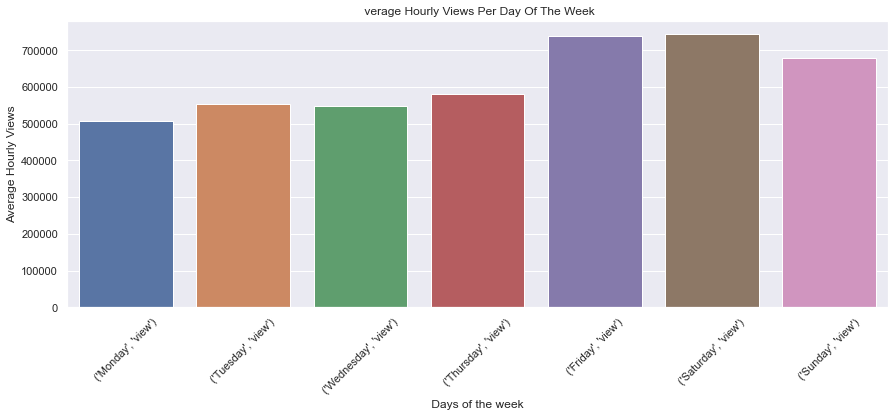

In [138]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(14.7, 5.27)
ax = sns.barplot(avg_views_daily.index,avg_views_daily.values)
ax.set(xlabel=' Days of the week ', ylabel='Average Hourly Views')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title(" verage Hourly Views Per Day Of The Week") 
plt.show()

#### <font color='blue'>As expected, Friday, Saturday and Sunday are the days with the most visitors on the site</font>


### <font color='purple'>Question 6:</font>
##### <font color='purple'>The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store? Find the overall conversion rate of your store.</font>

In [75]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()

In [76]:
dataset_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=["event_type"])

In [77]:
dataset_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=["event_type"])

In [78]:
dataset= pd.concat([dataset_oct,dataset_nov])

In [79]:
# increase free space of RAM
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()

In [ ]:
# We need the calculate the rate between how many times the products are 
# buyed and how many times the products are visited

In [81]:
tot_views= dataset["event_type"][dataset["event_type"]=="view"].count()         # total number of views
tot_purchases= dataset["event_type"][dataset["event_type"]=="purchase"].count() # total number of purchases
conversion_rate= tot_purchases/tot_views                                        # conversion rate of the online store
print("conversion_rate =",conversion_rate)

conversion_rate = 0.01590817944828352


### <font color='purple'>Question 6:</font>
#### <font color='purple'>Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.</font>

In [82]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


In [83]:
dataset_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=["event_type","category_code"])

In [84]:
dataset_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=["event_type","category_code"])

In [85]:
dataset_oct['category_code'] = dataset_oct['category_code'].str.split('.').str[0] # we extract the category
# the category is the first part of the "category_code" string

In [87]:
dataset_nov['category_code'] = dataset_nov['category_code'].str.split('.').str[0] 

In [88]:
dataset=pd.concat([dataset_oct,dataset_nov])

In [89]:
views_dataset=dataset[dataset["event_type"]=="view"] 

In [90]:
purchase_dataset=dataset[dataset["event_type"]=="purchase"] 

In [101]:
total_ourchased_cat=purchase_dataset.groupby("category_code").category_code.count().sort_values(ascending=False)

In [102]:
total_ourchased_cat.values

array([916667, 174022,  62332,  22217,  21339,  19843,  16500,  11648,
         3741,   2725,    654,    325,    132])

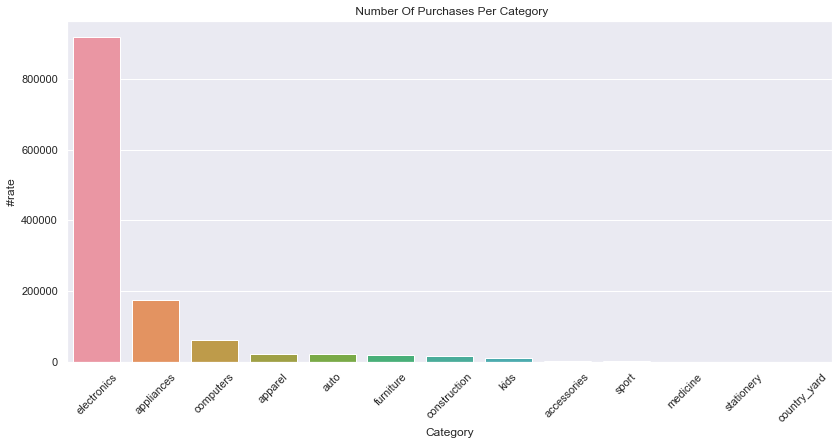

In [105]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 6.27)
ax  = sns.barplot(  total_ourchased_cat.index , total_ourchased_cat.values  )
ax.set(ylabel=' #rate ', xlabel='Category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title(" Number Of Purchases Per Category") 
plt.show()

#### <font color='blue'> We can see that the "electronics" category is the one with the highest number of purchases by a wide margin. This was expected, since "electronics" is also the most visited category</font>

In [94]:
# we show the conversion rate of each category in decreasing order
(purchase_dataset.groupby("category_code").event_type.count()/views_dataset.groupby("category_code").event_type.count()).sort_values(ascending=False)

category_code
electronics     0.024757
medicine        0.018827
stationery      0.016819
appliances      0.013555
computers       0.009897
auto            0.009890
construction    0.009376
kids            0.009015
sport           0.006565
accessories     0.006068
furniture       0.006022
apparel         0.004962
country_yard    0.004223
Name: event_type, dtype: float64

#### <font color='blue'> The "electronics" category also has the best conversion rate. At the second place we find "medicine". This makes sense because medicines are something users look for when they actually need them, so there is a good chance that a user who is looking for medicines on the site will also buy a medicine. </font>

### <font color='purple'>Question 7:</font>
#### <font color='purple'>The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers.Prove that the pareto principle applies to your store.</font>

In [25]:
dataset=pd.DataFrame()
dataset_oct=pd.DataFrame()
dataset_nov=pd.DataFrame()
gc.collect()
print("Free the memory")

Free the memory


In [25]:
dataset_oct = pd.read_csv('2019-Oct.csv', header='infer',usecols=["event_type","price","user_id"])
dataset_nov = pd.read_csv('2019-Nov.csv', header='infer',usecols=["event_type","price","user_id"])
dataset_oct = dataset_oct[dataset_oct["event_type"]=="purchase"]
dataset_nov = dataset_nov[dataset_nov["event_type"]=="purchase"]
dataset= pd.concat([dataset_oct,dataset_nov])

In [26]:
# We want to prove that the top 20% of our customers are responsible for at least the 80% of our total revenues
# We calculate the total revenues
tot_revenues=dataset["price"].sum()

# We calculate the total number of costumers
customers=dataset["user_id"].nunique()

# We calculate the revenues coming from the top 20% of customers
top20_revenues = dataset.groupby("user_id").price.sum().sort_values(ascending=False).head(customers//5).sum()

print("Percentage of the total revenues coming from the top 20% customers:")
(top20_revenues/tot_revenues)*100

Percentage of the total revenues coming from the top 20% customers:


72.10145671344638